### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *

### Create market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [5]:
def get_cj_env(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories),
                      arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate,arrival_rate]), 
                                                           step_size=step_size, 
                                                          num_trajectories=num_trajectories),
                      fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories),
                      reward_function = CjCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_cj_env(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [7]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"

### Define PPO policy

In [8]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [9]:
model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources

2022-09-13 17:10:51.957042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 17:10:51.957063: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Logging to ./tensorboard/PPO-learning-CJ/PPO_4
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 100        |
|    ep_rew_mean     | -4.0655675 |
| time/              |            |
|    fps             | 39005      |
|    iterations      | 1          |
|    time_elapsed    | 2          |
|    total_timesteps | 100000     |
-----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -2.586891    |
| time/                   |              |
|    fps                  | 29642        |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 200000       |
| train/                  |              |
|    approx_kl            | 0.0024639163 |
|    clip_fraction        | 0.0117       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84 

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 0.2549267   |
| time/                   |             |
|    fps                  | 26181       |
|    iterations           | 11          |
|    time_elapsed         | 42          |
|    total_timesteps      | 1100000     |
| train/                  |             |
|    approx_kl            | 0.004326618 |
|    clip_fraction        | 0.0378      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.676       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.495       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00206    |
|    std                  | 0.985       |
|    value_loss           | 0.997       |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 2.1904144    |
| time/                   |              |
|    fps                  | 27003        |
|    iterations           | 20           |
|    time_elapsed         | 74           |
|    total_timesteps      | 2000000      |
| train/                  |              |
|    approx_kl            | 0.0040227883 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.66        |
|    explained_variance   | 0.6          |
|    learning_rate        | 0.0003       |
|    loss                 | 0.274        |
|    n_updates            | 57           |
|    policy_gradient_loss | -0.00132     |
|    std                  | 0.912        |
|    value_loss           | 0.566        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 3.8108757    |
| time/                   |              |
|    fps                  | 26837        |
|    iterations           | 29           |
|    time_elapsed         | 108          |
|    total_timesteps      | 2900000      |
| train/                  |              |
|    approx_kl            | 0.0024996537 |
|    clip_fraction        | 0.0075       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.52        |
|    explained_variance   | 0.55         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.259        |
|    n_updates            | 84           |
|    policy_gradient_loss | -0.000313    |
|    std                  | 0.848        |
|    value_loss           | 0.515        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 3.9205363    |
| time/                   |              |
|    fps                  | 26464        |
|    iterations           | 38           |
|    time_elapsed         | 143          |
|    total_timesteps      | 3800000      |
| train/                  |              |
|    approx_kl            | 0.0012303132 |
|    clip_fraction        | 0.00414      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.38        |
|    explained_variance   | 0.546        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.299        |
|    n_updates            | 111          |
|    policy_gradient_loss | 2.71e-05     |
|    std                  | 0.794        |
|    value_loss           | 0.555        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 3.52051      |
| time/                   |              |
|    fps                  | 26331        |
|    iterations           | 47           |
|    time_elapsed         | 178          |
|    total_timesteps      | 4700000      |
| train/                  |              |
|    approx_kl            | 0.0012645272 |
|    clip_fraction        | 0.00236      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.28        |
|    explained_variance   | 0.551        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.293        |
|    n_updates            | 138          |
|    policy_gradient_loss | 0.000185     |
|    std                  | 0.753        |
|    value_loss           | 0.573        |
------------------------------------------
-----------------------------------------
| rollout/  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 4.16076      |
| time/                   |              |
|    fps                  | 26401        |
|    iterations           | 56           |
|    time_elapsed         | 212          |
|    total_timesteps      | 5600000      |
| train/                  |              |
|    approx_kl            | 0.0022628722 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.18        |
|    explained_variance   | 0.555        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.288        |
|    n_updates            | 165          |
|    policy_gradient_loss | -9.88e-05    |
|    std                  | 0.717        |
|    value_loss           | 0.577        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 3.6056638    |
| time/                   |              |
|    fps                  | 26461        |
|    iterations           | 65           |
|    time_elapsed         | 245          |
|    total_timesteps      | 6500000      |
| train/                  |              |
|    approx_kl            | 0.0018192042 |
|    clip_fraction        | 0.00356      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.09        |
|    explained_variance   | 0.564        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.285        |
|    n_updates            | 192          |
|    policy_gradient_loss | -0.000122    |
|    std                  | 0.684        |
|    value_loss           | 0.571        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 4.7781487    |
| time/                   |              |
|    fps                  | 26544        |
|    iterations           | 74           |
|    time_elapsed         | 278          |
|    total_timesteps      | 7400000      |
| train/                  |              |
|    approx_kl            | 0.0015819846 |
|    clip_fraction        | 0.0039       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.99        |
|    explained_variance   | 0.562        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.294        |
|    n_updates            | 219          |
|    policy_gradient_loss | 0.000177     |
|    std                  | 0.654        |
|    value_loss           | 0.6          |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 3.966787     |
| time/                   |              |
|    fps                  | 26381        |
|    iterations           | 83           |
|    time_elapsed         | 314          |
|    total_timesteps      | 8300000      |
| train/                  |              |
|    approx_kl            | 0.0025453996 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.93        |
|    explained_variance   | 0.569        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.296        |
|    n_updates            | 246          |
|    policy_gradient_loss | -0.000218    |
|    std                  | 0.632        |
|    value_loss           | 0.586        |
------------------------------------------
------------------------------------------
| rollout/ 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 3.6120892    |
| time/                   |              |
|    fps                  | 26374        |
|    iterations           | 92           |
|    time_elapsed         | 348          |
|    total_timesteps      | 9200000      |
| train/                  |              |
|    approx_kl            | 0.0022909346 |
|    clip_fraction        | 0.0082       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.84        |
|    explained_variance   | 0.547        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.323        |
|    n_updates            | 273          |
|    policy_gradient_loss | 1.03e-05     |
|    std                  | 0.605        |
|    value_loss           | 0.624        |
------------------------------------------
------------------------------------------
| rollout/ 

## Comparing the learnt policy to the optimal policy

In [10]:
from mbt_gym.agents.SbAgent import SbAgent

In [11]:
ppo_agent = SbAgent(model)

In [12]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5]]))
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

In [13]:
cj_agent = CarteaJaimungalAgent(phi = phi, alpha= alpha, env=get_cj_env())

In [14]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]])).reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

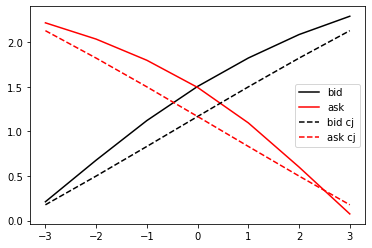

In [15]:
plt.plot(inventories, bid_actions, label = "bid", color = "k")
plt.plot(inventories, ask_actions, label = "ask", color = "r")
plt.plot(inventories, cj_bid_actions, label = "bid cj", color = "k", linestyle = "--")
plt.plot(inventories, cj_ask_actions, label = "ask cj", color = "r", linestyle = "--")
plt.legend()